In [1]:
%cd ../

/Users/macos/Uni/1st_year/period_4/ToolsHPC/hw/final/code


In [2]:
import subprocess
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.contrib.itertools import product
from loguru import logger

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

In [4]:
filename = Path("benchmarking/results.json")
filename.parent.mkdir(exist_ok=True, parents=True)

def write_result(result: dict):
    with open(filename, 'w+') as f:
        json.dump(result, f, indent=2)

def read_result() -> dict:
    if not filename.exists():
        return {}

    with open(filename) as f:
        d = json.load(f)

    return d

In [5]:
NUCS = [100, 120, 150, 250]
NUM_PROCS = [1, 2, 4, 5, 6]

dt = 0.001
maxt = 100000
vsc = 0.5
eout = 0

name_prog_parallel = "./bin/md2d_parallel"
name_prog_serial = "./bin/md2d"

results = read_result()

for nuc, num_procs in product(NUCS, NUM_PROCS):
    logger.info(f"Run: nuc = {nuc} - num_procs = {num_procs}")

    mode = "serial" if num_procs == 1 else "parallel"
    k = f"{mode}-{nuc}-{num_procs}"
    if k in results:
        continue

    if mode == "parallel":
        # Run parallel version
        result = subprocess.run(["mpirun", "-n", str(num_procs), name_prog_parallel, str(nuc), str(dt), str(maxt), str(vsc), str(eout)], stdout=subprocess.PIPE)
    elif mode == "serial":
        # Run original version
        result = subprocess.run([name_prog_serial, str(nuc), str(dt), str(maxt), str(vsc), str(eout)], stdout=subprocess.PIPE)
    else:
        raise NotImplementedError()
    
    results[k] = {
        'nuc': nuc,
        'num_procs': num_procs,
        'time': float(result.stdout.decode('utf-8')),
        'mode': mode,
    }

    write_result(results)



  0%|          | 0/20 [00:00<?, ?it/s]

2024-05-12 10:59:06.523 | INFO     | __main__:<module>:15 - Run: nuc = 100 - num_procs = 1
2024-05-12 10:59:06.527 | INFO     | __main__:<module>:15 - Run: nuc = 100 - num_procs = 2
2024-05-12 10:59:06.542 | INFO     | __main__:<module>:15 - Run: nuc = 100 - num_procs = 4
2024-05-12 10:59:06.547 | INFO     | __main__:<module>:15 - Run: nuc = 100 - num_procs = 5
2024-05-12 10:59:06.549 | INFO     | __main__:<module>:15 - Run: nuc = 100 - num_procs = 6
2024-05-12 10:59:06.550 | INFO     | __main__:<module>:15 - Run: nuc = 120 - num_procs = 1
2024-05-12 10:59:06.551 | INFO     | __main__:<module>:15 - Run: nuc = 120 - num_procs = 2
2024-05-12 10:59:06.552 | INFO     | __main__:<module>:15 - Run: nuc = 120 - num_procs = 4
2024-05-12 10:59:06.553 | INFO     | __main__:<module>:15 - Run: nuc = 120 - num_procs = 5
2024-05-12 10:59:06.555 | INFO     | __main__:<module>:15 - Run: nuc = 120 - num_procs = 6
2024-05-12 10:59:06.557 | INFO     | __main__:<module>:15 - Run: nuc = 150 - num_procs = 1

In [6]:
df = pd.DataFrame.from_records(list(results.values())).sort_values(by='mode')

df.head()

,nuc,num_procs,time,mode
9,120,6,67.116,parallel
17,250,4,150.321,parallel
16,250,2,279.834,parallel
14,150,6,101.060,parallel
13,150,5,84.146,parallel


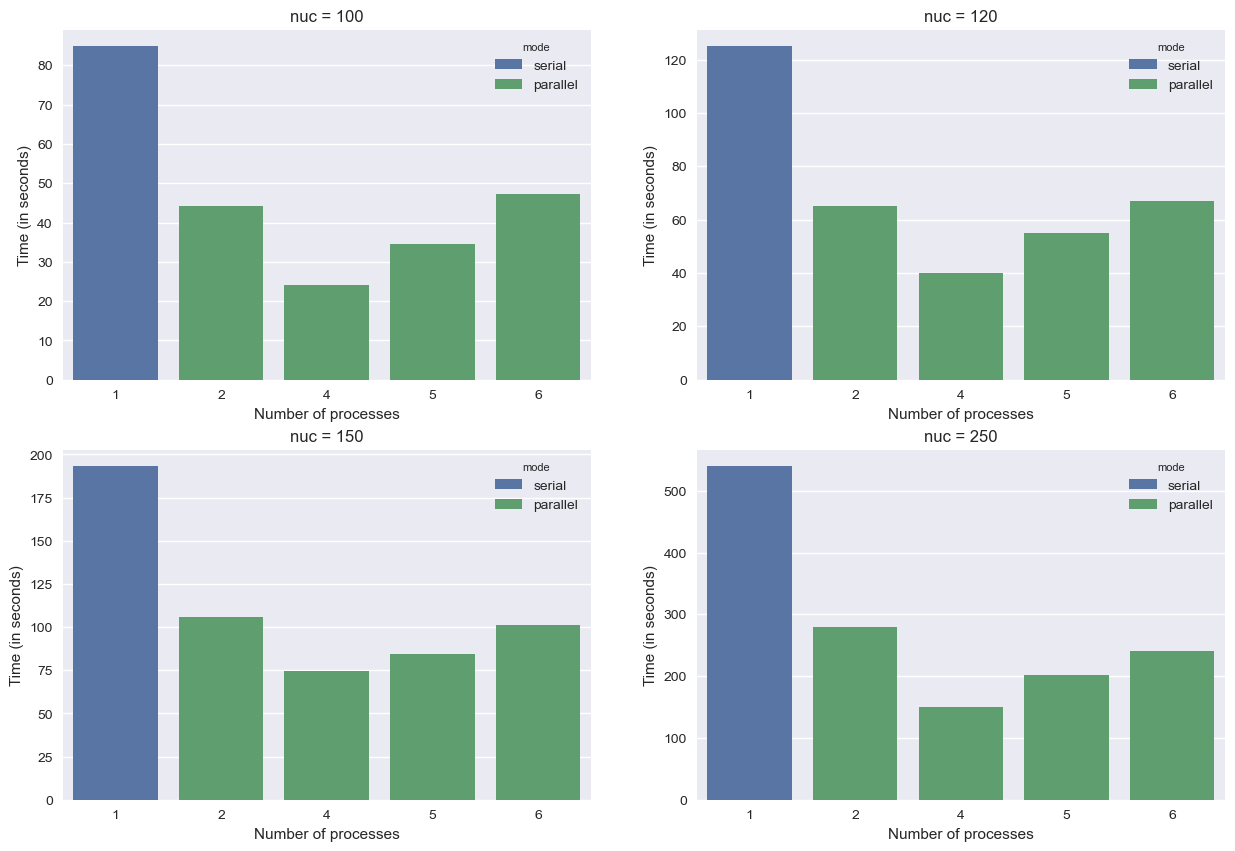

In [7]:
fig = plt.figure(figsize=(15, 10))

for i, nuc in enumerate(sorted(df['nuc'].unique())):
    # break

    ax = fig.add_subplot(2, 2, i+1)

    df_nuc = df[df['nuc'] == nuc]

    sns.barplot(df_nuc, x='num_procs', y='time', hue='mode')
    ax.set_xlabel("Number of processes")
    ax.set_ylabel("Time (in seconds)")

    ax.set_title(f"nuc = {nuc}")

fig.savefig("benchmarking/results_barplot.png", bbox_inches='tight')